<a href="https://colab.research.google.com/github/ceginer/DSBA_coding_test_CV/blob/main/Coding_test_CV_%EC%86%90%EB%B3%91%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSBA Coding Test - CV

- **이름**: 손병우

이미지 데이터 학습을 위한 코드와 결과물 정리 코드 작성입니다.

실험 및 상세 조건들은 아래와 같습니다.

- 모든 코드는 colab을 사용하여 notebook 파일 내 작성

1. 주제 : 이미지 데이터 학습을 위한 코드 및 결과물 정리
    - 실험을 위한 모델 코드와 학습 및 평가 코드 작성
    - 실험 결과 작성
2. 학습 모델
    - ResNet50
    - ViT-S/16
3. 실험 항목
    1. ResNet50 w/o pre-trained weights
    2. ViT-S/16 w/o pre-trained weights
    3. ResNet50 w/ pre-trained on ImageNet 1k
    4. ViT-S/16 w/ pre-trained on ImageNet 1k
4. 실험 결과
    - 결과로 보일 수 있는 Table, Figure 모두 작성

# Data Download

In [20]:
import gdown

url = "https://drive.google.com/drive/folders/1wEnwMeJoQZwJhI7oBRah3I8QX-FpLMYD"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/data/test_data.npy',
 '/content/data/test_target.npy',
 '/content/data/train_data.npy',
 '/content/data/train_target.npy']

# Import Modules

실험에 사용된 module은 모두 아래 cell에서 불러와주세요.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install omegaconf
!pip install timm
!pip install grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import timm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm
from omegaconf import OmegaConf
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configuration

코드에 사용된 설정 값은 모두 `cfg`에 정의해주세요.

In [6]:
cfg = OmegaConf.create({

    # 데이터셋 관련 설정
    "data": {
        "batch_size": 64,
        "num_workers": 4,
        "resize": [224, 224],
        "norm_mean": [0.5, 0.5, 0.5],
        "norm_std": [0.5, 0.5, 0.5],
        "num_classes": 10,
    },

    # 모델 저장 관련 설정
    "checkpoint": {
        "dir": "./checkpoints"
    },

    # 시각화 관련 설정
    "visualization": {
        "save_dir": "./figures",
    },

    # 학습 파라미터
    "training": {
        "total_epochs": 30,
        "lr": 1e-4,
        "loss": "CrossEntropyLoss",
        "optimizer": "Adam",
        "seed": 42,
        "device": "cuda:0" if torch.cuda.is_available() else "cpu",
        "patience": 10,
    },

    ## 실험 설정
    "experiment": {
        # Experiment 반복
        "experiments": [
            {"model": "ResNet50", "model_type": "resnet", "pretrained": False},
            {"model": "ViT-S", "model_type": "vit", "pretrained": False},
            {"model": "ResNet50", "model_type": "resnet", "pretrained": True},
            {"model": "ViT-S", "model_type": "vit", "pretrained": True}
        ]
    }
})

# YAML 파일로 저장
with open("config.yaml", "w") as f:
    OmegaConf.save(cfg, f=f.name)


# Datasets

실험에 사용할 데이터를 구성해주세요.  

## (1) EDA

In [7]:
# path 설정
test_data_path = "data/test_data.npy"
test_target_path = "data/test_target.npy"
train_data_path = "data/train_data.npy"
train_target_path = "data/train_target.npy"

# Data load
test_data = np.load(test_data_path)
test_target = np.load(test_target_path)
train_data = np.load(train_data_path)
train_target = np.load(train_target_path)

In [8]:
# 데이터 구조와 크기 확인
print("test_data shape:", test_data.shape)
print("test_target shape:", test_target.shape)
print("train_data shape:", train_data.shape)
print("train_target shape:", train_target.shape)

# 샘플 확인
# print("\nTrain Data Sample:\n", train_data[:2])
print("\nTrain Target Sample:", train_target[:])
# print("\nTest Data Sample:\n", test_data[:2])
print("\nTest Target Sample:", test_target[:])

test_data shape: (10000, 32, 32, 3)
test_target shape: (10000,)
train_data shape: (20431, 32, 32, 3)
train_target shape: (20431,)

Train Target Sample: [0 0 0 ... 9 9 9]

Test Target Sample: [3 8 8 ... 5 1 7]


### 1. 시각화

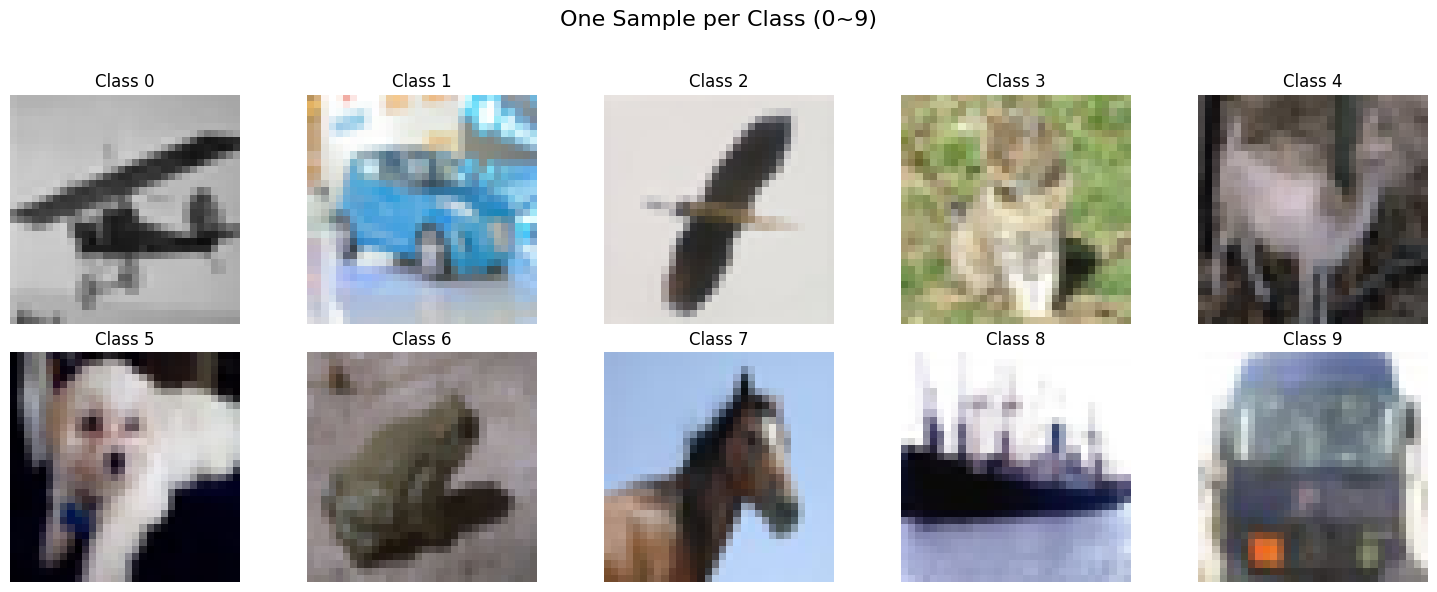

In [9]:
# 클래스별로 하나씩 이미지 수집
class_to_image = {}
for img, label in zip(train_data, train_target):
    label = int(label)
    if label not in class_to_image:
        class_to_image[label] = img
    if len(class_to_image) == 10:
        break

# 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (label, image) in enumerate(sorted(class_to_image.items())):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(f"Class {label}")
    ax.axis("off")

# 저장 경로가 없다면 생성
os.makedirs(cfg.visualization.save_dir, exist_ok=True)

plt.suptitle("One Sample per Class (0~9)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(cfg.visualization.save_dir, "Data_samples.png"))
plt.show()
plt.close()


### 2. Data distribution

Unique labels in train target: [0 1 2 3 4 5 6 7 8 9]
Counts of each label in train target: [5000 3871 2997 2320 1796 1391 1077  834  645  500]
Unique labels in test target: [0 1 2 3 4 5 6 7 8 9]
Counts of each label in test target: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


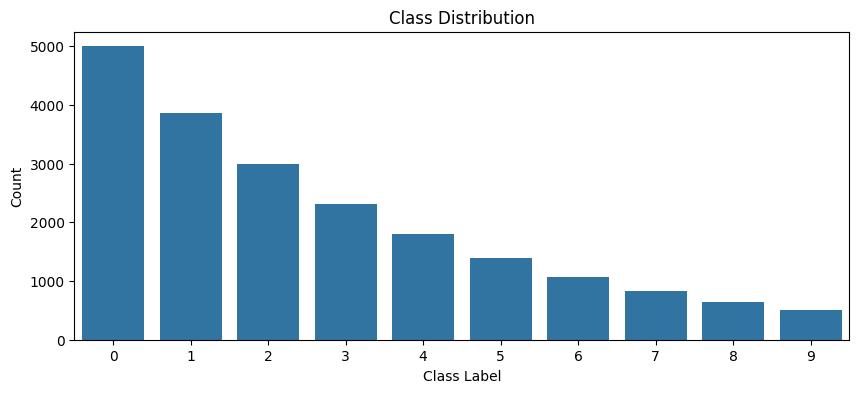

In [10]:
# train 라벨별 개수 확인
unique, counts = np.unique(train_target, return_counts=True)
print("Unique labels in train target:", unique)
print("Counts of each label in train target:", counts)

# test 라벨별 개수 확인
test_unique, test_counts = np.unique(test_target, return_counts=True)
print("Unique labels in test target:", test_unique)
print("Counts of each label in test target:", test_counts)

# train 라벨 분포 시각화
plt.figure(figsize=(10, 4))
sns.barplot(x=unique, y=counts)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.savefig(os.path.join(cfg.visualization.save_dir, "Class_distribution.png"))  # 원하는 경로와 파일명 지정
plt.show()


## (2) Dataset & Dataloader

In [11]:
# 1. 사용자 정의 Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # uint8 → PIL 이미지로 변환
        image = Image.fromarray(image)

        # transform 적용
        if self.transform:
            image = self.transform(image)

        return image, label


# 2. transform 구성
train_transform = transforms.Compose([
    transforms.Resize(cfg.data.resize), # [224, 224] 크기로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(cfg.data.norm_mean, cfg.data.norm_std) # 채널별 0.5로 정규화
])

test_transform = transforms.Compose([
    transforms.Resize(cfg.data.resize), # [224, 224] 크기로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(cfg.data.norm_mean, cfg.data.norm_std) # 채널별 0.5로 정규화
])

# 3. Dataset 및 DataLoader
train_dataset = CustomDataset(train_data, train_target, train_transform)
test_dataset = CustomDataset(test_data, test_target, test_transform)

train_loader = DataLoader(train_dataset, batch_size=cfg.data.batch_size, shuffle=True, num_workers=cfg.data.num_workers)
test_loader = DataLoader(test_dataset, batch_size=cfg.data.batch_size, shuffle=False, num_workers=cfg.data.num_workers)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


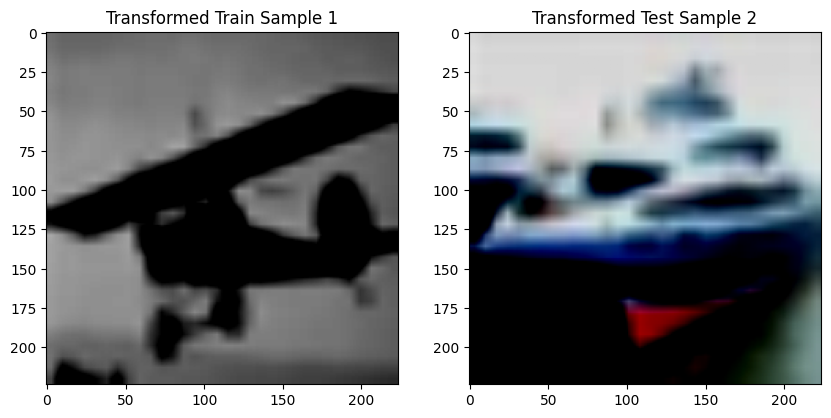

In [12]:
# train_dataset
train_sample1 = train_dataset[0][0]
test_sample2 = test_dataset[1][0]

# visiualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_sample1.permute(1, 2, 0).numpy())
plt.title("Transformed Train Sample 1")
plt.subplot(1, 2, 2)
plt.imshow(test_sample2.permute(1, 2, 0).numpy())
plt.title("Transformed Test Sample 2")
plt.savefig(os.path.join(cfg.visualization.save_dir, "Transformed_samples.png"))
plt.show()


# Models

`ResNet50`과 `ViT-S/16` 두 모델을 작성해주세요.
- `ResNet50`은 torch를 사용하여 작성해주세요.
- `ViT-S/16`은 open source를 사용하여 불러와도 괜찮습니다.

## (1) ResNet-50

In [13]:
# 3.1 ResNet-50

### BottleNeck Block
class BottleNeck(nn.Module):
    '''
    - ResNet-50 에서부터 사용되는 BottleNeck Block
    - 각 Block의 conv1 - layer 1(Maxpooling) 제외 나머지 stride =2 적용/ 잔차 연결을 위한 downsampling
    - 각 Block 의 conv layer와 activation layer 사이에 batch normalization 적용
    - conv 2_x 을 제외한 나머지 channel 변화 : in_channel -> half -> half*4(=expansion)
    '''

    # channel 변화에 따른 출력 차원 수 증가
    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        ## (1) 1x1 conv
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        ## (2) 3x3 conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ## (3) 1x1 conv
        # 다음 계층을 위한 out_channels * self.expansion(= 4) 필요
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        ## activation function - ReLU
        self.relu = nn.ReLU()

        ## DownSampling
        # Residual Connection을 위해 적용
        self.downsample = None
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )


    def forward(self, x):
        # identity mapping(skip connection)을 위한 original input 저장
        i = x

        ## Conv (1),(2),(3) Block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x) # activation 적용 X

        ## i 연결을 위한 DownSampling
        if self.downsample is not None:
            i = self.downsample(i)

        ## Identity Mapping(Residual Connection)
        x += i
        x = self.relu(x) # identity mapping 후 activation 적용

        return x


### ResNet50 Model
class ResNet50(nn.Module):
    '''
    - ResNet-50 에서부터 사용되는 BottleNeck Block
    - 각 Block의 conv1 - layer 1(Maxpooling) 제외 나머지 stride =2 적용/ 잔차 연결을 위한 downsampling
    - 각 Block 의 conv layer와 activation layer 사이에 batch normalization 적용
    - conv 2_x 을 제외한 나머지 channel 변화 : in_channel -> half -> half*4(=expansion)
    '''
    def __init__(self, num_classes = 10):
        super().__init__()

        # 초기 입력 채널
        self.in_channels = 64

        ## (1) conv1
        # 7x7 Conv + BatchNorm + ReLU
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU()

        ## (2) conv 2_x
        # Maxpooling(3x3) + Residual block(64, 64, 256) x 3
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self.make_layer(BottleNeck, 64, 3)

        ## (3) conv 3_x
        # Residual block(128, 128, 512) x 4
        self.layer2 = self.make_layer(BottleNeck, 128, 4, stride = 2)

        ## (4) conv 4_x
        # Residual block(256, 256, 1024) x 6
        self.layer3 = self.make_layer(BottleNeck, 256, 6, stride = 2)

        ## (5) conv 5_x
        # Residual block(512, 512, 2048) x 3
        self.layer4 = self.make_layer(BottleNeck, 512, 3, stride = 2)

        ## (6) Avg Pool + FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BottleNeck.expansion, num_classes)


    ## ResNet의 (2)~(5) 까지의 각 Stage 구성 블록 생성
    def make_layer(self, block, out_channels, num_blocks, stride = 1):
        layers = []

        # 첫 블록은 downsampling 적용 - feature map 형태 맞춰주기 위함
        layers.append(block(self.in_channels, out_channels, stride, downsample = True))

        # BottleNeck Block의 expansion을 고려하여 in_channels 업데이트
        self.in_channels = out_channels * block.expansion

        # 이외 블록들은 downsampling 없이 추가
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        ## conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        ## conv2_x
        x = self.maxpool(x)
        x = self.layer1(x)

        ## conv3_x
        x = self.layer2(x)

        ## conv4_x
        x = self.layer3(x)

        ## conv5_x
        x = self.layer4(x)

        ## Avg Pool + FC layer
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)  # flatten
        x = self.fc(h)

        return x

## (2) ViT-S/16

In [14]:
# 3.2 ViT-S/16 모델 불러오기

class ViT_S(nn.Module):
    def __init__(self, pretrained=True, num_classes=10):
        super().__init__()

        # timm에서 사전학습 모델 불러오기
        self.backbone = timm.create_model(
            "vit_small_patch16_224",
            pretrained=pretrained,
            num_classes=1000  # ImageNet 헤드 (무시 예정)
        )

        # 새로운 FC layer 정의
        in_features = self.backbone.head.in_features
        self.fc = nn.Linear(in_features, num_classes)

        # 기존 timm head 제거 후 새 fc로 교체
        self.backbone.head = self.fc

    def forward(self, x):
        return self.backbone(x)


# Evaluation Metrics

평가에 사용할 코드를 작성하세요.

In [15]:
def compute_metrics(y_true, y_pred, average='macro'):
    test_accuracy= accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    return test_accuracy, precision, recall, f1

# Training & Evaluation

학습 및 평가 코드를 작성하세요.

In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training", leave=True,  unit="batch")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [17]:
def evaluate_model(model, dataloader, criterion, device, average='macro'):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    avg_loss = total_loss / len(dataloader.dataset)

    # metric 계산
    test_accuracy, precision, recall, f1 = compute_metrics(y_true, y_pred, average=average)

    return {
        "Test loss": avg_loss,
        "Test accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_score": f1
    }


# Experiments

실험 코드를 작성하세요.

In [ ]:
# 실험 설정
device = cfg.training.device
experiments = cfg.experiment.experiments
num_classes = cfg.data.num_classes # num_classes = 10
patience = cfg.training.patience
early_stop_counter = 0
experiment_order = []



# 전체 실험 반복
for exp_cfg in experiments:

    epoch_logs = []

    # (0) experiments 세팅
    model_name = exp_cfg["model"]
    pretrained = exp_cfg["pretrained"]
    exp_name = f"{model_name}_{'pretrained' if pretrained else 'scratch'}"
    experiment_order.append(exp_name)  # 순서 기록

    print(f"===== Starting Experiment: {exp_name} ======")

    # (1) 모델 구성
    if model_name == "ResNet50":
        if pretrained:
            model = ResNet50(num_classes=1000)
            state_dict = torch.hub.load_state_dict_from_url(
                "https://download.pytorch.org/models/resnet50-19c8e357.pth",
                map_location="cpu"
            )
            model.load_state_dict(state_dict, strict=False)

            # fc 덮어쓰기 (10-class)
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, num_classes)

        else:
            model = ResNet50(num_classes= 10)

    elif model_name == "ViT-S":
        model = ViT_S(pretrained=pretrained, num_classes=10)

    model = model.to(device)

    # (2) 옵티마이저 및 손실 함수
    optimizer = optim.Adam(model.parameters(), lr=cfg.training.lr)
    criterion = nn.CrossEntropyLoss()

    # (3) Intialize history
    best_acc = 0.0

    # (4) Train & Evaluate
    for epoch in range(cfg.training.total_epochs):
        print(f"Epoch {epoch+1}/{cfg.training.total_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)        #
        val_metrics = evaluate_model(model, test_loader, criterion, device)

        # 로깅
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print("=== Evaluation Results ===")
        for k, v in val_metrics.items():
            print(f"  {k:<12}: {v:.4f}")

        # 로깅 저장
        epoch_logs.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": val_metrics["Test loss"],
            "test_acc": val_metrics["Test accuracy"],
            "precision": val_metrics["Precision"],
            "recall": val_metrics["Recall"],
            "f1_score": val_metrics["F1_score"]
        })

        if val_metrics["Test accuracy"] > best_acc:
            best_acc = val_metrics["Test accuracy"]
            torch.save(model.state_dict(), os.path.join(cfg.checkpoint.dir, f"best_{exp_name}.pth"))
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # (5) 실험 결과 정리
    # results 폴더가 없다면 생성
    os.makedirs("./results", exist_ok=True)

    # DataFrame으로 변환 후 저장
    df = pd.DataFrame(epoch_logs)
    df.to_csv(f"./results/{exp_name}.csv", index=False)

===== Starting Experiment: ResNet50_scratch ======
Epoch 1/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.03batch/s]


Train Loss: 1.4807 | Train Acc: 0.4851
=== Evaluation Results ===
  Test loss   : 1.7974
  Test accuracy: 0.3645
  Precision   : 0.4634
  Recall      : 0.3645
  F1_score    : 0.3184
Epoch 2/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 1.1759 | Train Acc: 0.5827
=== Evaluation Results ===
  Test loss   : 1.3861
  Test accuracy: 0.4919
  Precision   : 0.5732
  Recall      : 0.4919
  F1_score    : 0.4787
Epoch 3/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.9642 | Train Acc: 0.6613
=== Evaluation Results ===
  Test loss   : 1.3685
  Test accuracy: 0.5225
  Precision   : 0.6291
  Recall      : 0.5225
  F1_score    : 0.4955
Epoch 4/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.7964 | Train Acc: 0.7166
=== Evaluation Results ===
  Test loss   : 1.2118
  Test accuracy: 0.5739
  Precision   : 0.7000
  Recall      : 0.5739
  F1_score    : 0.5786
Epoch 5/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.6601 | Train Acc: 0.7667
=== Evaluation Results ===
  Test loss   : 1.1729
  Test accuracy: 0.5994
  Precision   : 0.7175
  Recall      : 0.5994
  F1_score    : 0.6004
Epoch 6/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.5328 | Train Acc: 0.8144
=== Evaluation Results ===
  Test loss   : 1.6153
  Test accuracy: 0.5455
  Precision   : 0.6782
  Recall      : 0.5455
  F1_score    : 0.5214
Early stopping counter: 1/10
Epoch 7/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 0.4113 | Train Acc: 0.8572
=== Evaluation Results ===
  Test loss   : 1.0906
  Test accuracy: 0.6629
  Precision   : 0.7085
  Recall      : 0.6629
  F1_score    : 0.6581
Epoch 8/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.3087 | Train Acc: 0.8931
=== Evaluation Results ===
  Test loss   : 1.3379
  Test accuracy: 0.6295
  Precision   : 0.7031
  Recall      : 0.6295
  F1_score    : 0.6206
Early stopping counter: 1/10
Epoch 9/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.2232 | Train Acc: 0.9244
=== Evaluation Results ===
  Test loss   : 1.6203
  Test accuracy: 0.5912
  Precision   : 0.6948
  Recall      : 0.5912
  F1_score    : 0.5753
Early stopping counter: 2/10
Epoch 10/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.04batch/s]


Train Loss: 0.1826 | Train Acc: 0.9384
=== Evaluation Results ===
  Test loss   : 1.2521
  Test accuracy: 0.6853
  Precision   : 0.7180
  Recall      : 0.6853
  F1_score    : 0.6760
Epoch 11/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.1187 | Train Acc: 0.9597
=== Evaluation Results ===
  Test loss   : 1.6312
  Test accuracy: 0.6342
  Precision   : 0.6996
  Recall      : 0.6342
  F1_score    : 0.6294
Early stopping counter: 1/10
Epoch 12/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.04batch/s]


Train Loss: 0.1011 | Train Acc: 0.9642
=== Evaluation Results ===
  Test loss   : 1.6334
  Test accuracy: 0.6442
  Precision   : 0.7190
  Recall      : 0.6442
  F1_score    : 0.6356
Early stopping counter: 2/10
Epoch 13/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.1097 | Train Acc: 0.9629
=== Evaluation Results ===
  Test loss   : 1.5974
  Test accuracy: 0.6635
  Precision   : 0.7091
  Recall      : 0.6635
  F1_score    : 0.6628
Early stopping counter: 3/10
Epoch 14/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0848 | Train Acc: 0.9722
=== Evaluation Results ===
  Test loss   : 1.6354
  Test accuracy: 0.6559
  Precision   : 0.7289
  Recall      : 0.6559
  F1_score    : 0.6668
Early stopping counter: 4/10
Epoch 15/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.1005 | Train Acc: 0.9635
=== Evaluation Results ===
  Test loss   : 1.9006
  Test accuracy: 0.6175
  Precision   : 0.6987
  Recall      : 0.6175
  F1_score    : 0.6048
Early stopping counter: 5/10
Epoch 16/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0820 | Train Acc: 0.9715
=== Evaluation Results ===
  Test loss   : 1.3874
  Test accuracy: 0.7042
  Precision   : 0.7434
  Recall      : 0.7042
  F1_score    : 0.7115
Epoch 17/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.04batch/s]


Train Loss: 0.0583 | Train Acc: 0.9810
=== Evaluation Results ===
  Test loss   : 1.4807
  Test accuracy: 0.6686
  Precision   : 0.7303
  Recall      : 0.6686
  F1_score    : 0.6726
Early stopping counter: 1/10
Epoch 18/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0801 | Train Acc: 0.9721
=== Evaluation Results ===
  Test loss   : 1.7761
  Test accuracy: 0.6504
  Precision   : 0.7068
  Recall      : 0.6504
  F1_score    : 0.6477
Early stopping counter: 2/10
Epoch 19/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0612 | Train Acc: 0.9778
=== Evaluation Results ===
  Test loss   : 1.8779
  Test accuracy: 0.6354
  Precision   : 0.7040
  Recall      : 0.6354
  F1_score    : 0.6223
Early stopping counter: 3/10
Epoch 20/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.02batch/s]


Train Loss: 0.0754 | Train Acc: 0.9730
=== Evaluation Results ===
  Test loss   : 1.2261
  Test accuracy: 0.7234
  Precision   : 0.7385
  Recall      : 0.7234
  F1_score    : 0.7259
Epoch 21/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0319 | Train Acc: 0.9898
=== Evaluation Results ===
  Test loss   : 1.4666
  Test accuracy: 0.7020
  Precision   : 0.7233
  Recall      : 0.7020
  F1_score    : 0.7008
Early stopping counter: 1/10
Epoch 22/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.00batch/s]


Train Loss: 0.0569 | Train Acc: 0.9809
=== Evaluation Results ===
  Test loss   : 1.5650
  Test accuracy: 0.6855
  Precision   : 0.7284
  Recall      : 0.6855
  F1_score    : 0.6841
Early stopping counter: 2/10
Epoch 23/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0828 | Train Acc: 0.9710
=== Evaluation Results ===
  Test loss   : 1.6365
  Test accuracy: 0.6763
  Precision   : 0.7248
  Recall      : 0.6763
  F1_score    : 0.6777
Early stopping counter: 3/10
Epoch 24/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.03batch/s]


Train Loss: 0.0373 | Train Acc: 0.9879
=== Evaluation Results ===
  Test loss   : 1.5854
  Test accuracy: 0.6866
  Precision   : 0.7272
  Recall      : 0.6866
  F1_score    : 0.6882
Early stopping counter: 4/10
Epoch 25/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0437 | Train Acc: 0.9844
=== Evaluation Results ===
  Test loss   : 1.5518
  Test accuracy: 0.6875
  Precision   : 0.7220
  Recall      : 0.6875
  F1_score    : 0.6886
Early stopping counter: 5/10
Epoch 26/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.05batch/s]


Train Loss: 0.0618 | Train Acc: 0.9788
=== Evaluation Results ===
  Test loss   : 1.8332
  Test accuracy: 0.6666
  Precision   : 0.7358
  Recall      : 0.6666
  F1_score    : 0.6649
Early stopping counter: 6/10
Epoch 27/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0467 | Train Acc: 0.9834
=== Evaluation Results ===
  Test loss   : 1.4206
  Test accuracy: 0.7130
  Precision   : 0.7363
  Recall      : 0.7130
  F1_score    : 0.7103
Early stopping counter: 7/10
Epoch 28/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0525 | Train Acc: 0.9825
=== Evaluation Results ===
  Test loss   : 1.6472
  Test accuracy: 0.6819
  Precision   : 0.7379
  Recall      : 0.6819
  F1_score    : 0.6855
Early stopping counter: 8/10
Epoch 29/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0380 | Train Acc: 0.9872
=== Evaluation Results ===
  Test loss   : 1.5152
  Test accuracy: 0.7095
  Precision   : 0.7390
  Recall      : 0.7095
  F1_score    : 0.7094
Early stopping counter: 9/10
Epoch 30/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.03batch/s]


Train Loss: 0.0298 | Train Acc: 0.9901
=== Evaluation Results ===
  Test loss   : 1.7240
  Test accuracy: 0.6908
  Precision   : 0.7277
  Recall      : 0.6908
  F1_score    : 0.6890
Early stopping counter: 10/10
Early stopping triggered at epoch 30
===== Starting Experiment: ViT-S_scratch ======
Epoch 1/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]
/opt/conda/envs/dsba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.6590 | Train Acc: 0.4156
=== Evaluation Results ===
  Test loss   : 1.9251
  Test accuracy: 0.2866
  Precision   : 0.2970
  Recall      : 0.2866
  F1_score    : 0.2028
Epoch 2/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.00batch/s]
/opt/conda/envs/dsba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.4350 | Train Acc: 0.4934
=== Evaluation Results ===
  Test loss   : 1.9863
  Test accuracy: 0.2482
  Precision   : 0.4805
  Recall      : 0.2482
  F1_score    : 0.1783
Early stopping counter: 1/10
Epoch 3/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.93batch/s]


Train Loss: 1.3512 | Train Acc: 0.5226
=== Evaluation Results ===
  Test loss   : 1.8552
  Test accuracy: 0.3610
  Precision   : 0.4254
  Recall      : 0.3610
  F1_score    : 0.3124
Epoch 4/30


Training: 100%|██████████| 320/320 [01:04<00:00,  5.00batch/s]


Train Loss: 1.2604 | Train Acc: 0.5595
=== Evaluation Results ===
  Test loss   : 1.5705
  Test accuracy: 0.4255
  Precision   : 0.5166
  Recall      : 0.4255
  F1_score    : 0.3923
Epoch 5/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.00batch/s]


Train Loss: 1.2037 | Train Acc: 0.5724
=== Evaluation Results ===
  Test loss   : 1.5729
  Test accuracy: 0.4161
  Precision   : 0.5497
  Recall      : 0.4161
  F1_score    : 0.3737
Early stopping counter: 1/10
Epoch 6/30


Training: 100%|██████████| 320/320 [01:04<00:00,  5.00batch/s]


Train Loss: 1.1376 | Train Acc: 0.5974
=== Evaluation Results ===
  Test loss   : 1.4931
  Test accuracy: 0.4506
  Precision   : 0.5660
  Recall      : 0.4506
  F1_score    : 0.4196
Epoch 7/30


Training: 100%|██████████| 320/320 [01:04<00:00,  5.00batch/s]


Train Loss: 1.0823 | Train Acc: 0.6134
=== Evaluation Results ===
  Test loss   : 1.3966
  Test accuracy: 0.4893
  Precision   : 0.5702
  Recall      : 0.4893
  F1_score    : 0.4701
Epoch 8/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 1.0309 | Train Acc: 0.6337
=== Evaluation Results ===
  Test loss   : 1.4967
  Test accuracy: 0.4654
  Precision   : 0.5926
  Recall      : 0.4654
  F1_score    : 0.4233
Early stopping counter: 1/10
Epoch 9/30


Training: 100%|██████████| 320/320 [01:05<00:00,  4.91batch/s]


Train Loss: 0.9936 | Train Acc: 0.6450
=== Evaluation Results ===
  Test loss   : 1.3944
  Test accuracy: 0.5028
  Precision   : 0.5912
  Recall      : 0.5028
  F1_score    : 0.4929
Epoch 10/30


Training: 100%|██████████| 320/320 [01:05<00:00,  4.91batch/s]


Train Loss: 0.9420 | Train Acc: 0.6626
=== Evaluation Results ===
  Test loss   : 1.4568
  Test accuracy: 0.4827
  Precision   : 0.5904
  Recall      : 0.4827
  F1_score    : 0.4609
Early stopping counter: 1/10
Epoch 11/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.8942 | Train Acc: 0.6788
=== Evaluation Results ===
  Test loss   : 1.4697
  Test accuracy: 0.4910
  Precision   : 0.6080
  Recall      : 0.4910
  F1_score    : 0.4580
Early stopping counter: 2/10
Epoch 12/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.8497 | Train Acc: 0.6943
=== Evaluation Results ===
  Test loss   : 1.2983
  Test accuracy: 0.5449
  Precision   : 0.6077
  Recall      : 0.5449
  F1_score    : 0.5330
Epoch 13/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.8194 | Train Acc: 0.7073
=== Evaluation Results ===
  Test loss   : 1.3729
  Test accuracy: 0.5307
  Precision   : 0.6247
  Recall      : 0.5307
  F1_score    : 0.5316
Early stopping counter: 1/10
Epoch 14/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.7701 | Train Acc: 0.7191
=== Evaluation Results ===
  Test loss   : 1.3361
  Test accuracy: 0.5436
  Precision   : 0.6221
  Recall      : 0.5436
  F1_score    : 0.5391
Early stopping counter: 2/10
Epoch 15/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.97batch/s]


Train Loss: 0.7278 | Train Acc: 0.7400
=== Evaluation Results ===
  Test loss   : 1.6147
  Test accuracy: 0.5196
  Precision   : 0.6088
  Recall      : 0.5196
  F1_score    : 0.4904
Early stopping counter: 3/10
Epoch 16/30


Training: 100%|██████████| 320/320 [01:05<00:00,  4.91batch/s]


Train Loss: 0.6963 | Train Acc: 0.7491
=== Evaluation Results ===
  Test loss   : 1.3334
  Test accuracy: 0.5374
  Precision   : 0.6217
  Recall      : 0.5374
  F1_score    : 0.5206
Early stopping counter: 4/10
Epoch 17/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.97batch/s]


Train Loss: 0.6539 | Train Acc: 0.7648
=== Evaluation Results ===
  Test loss   : 1.3139
  Test accuracy: 0.5788
  Precision   : 0.6170
  Recall      : 0.5788
  F1_score    : 0.5724
Epoch 18/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.95batch/s]


Train Loss: 0.6195 | Train Acc: 0.7755
=== Evaluation Results ===
  Test loss   : 1.3057
  Test accuracy: 0.5793
  Precision   : 0.6221
  Recall      : 0.5793
  F1_score    : 0.5714
Epoch 19/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.5700 | Train Acc: 0.7954
=== Evaluation Results ===
  Test loss   : 1.4263
  Test accuracy: 0.5540
  Precision   : 0.6329
  Recall      : 0.5540
  F1_score    : 0.5449
Early stopping counter: 1/10
Epoch 20/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.5300 | Train Acc: 0.8067
=== Evaluation Results ===
  Test loss   : 1.4055
  Test accuracy: 0.5781
  Precision   : 0.6169
  Recall      : 0.5781
  F1_score    : 0.5688
Early stopping counter: 2/10
Epoch 21/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.97batch/s]


Train Loss: 0.4882 | Train Acc: 0.8256
=== Evaluation Results ===
  Test loss   : 1.4447
  Test accuracy: 0.5734
  Precision   : 0.6349
  Recall      : 0.5734
  F1_score    : 0.5719
Early stopping counter: 3/10
Epoch 22/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.4552 | Train Acc: 0.8345
=== Evaluation Results ===
  Test loss   : 1.5063
  Test accuracy: 0.5628
  Precision   : 0.6199
  Recall      : 0.5628
  F1_score    : 0.5577
Early stopping counter: 4/10
Epoch 23/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.4084 | Train Acc: 0.8537
=== Evaluation Results ===
  Test loss   : 1.5513
  Test accuracy: 0.5721
  Precision   : 0.6236
  Recall      : 0.5721
  F1_score    : 0.5655
Early stopping counter: 5/10
Epoch 24/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.3784 | Train Acc: 0.8638
=== Evaluation Results ===
  Test loss   : 1.6007
  Test accuracy: 0.5555
  Precision   : 0.5969
  Recall      : 0.5555
  F1_score    : 0.5472
Early stopping counter: 6/10
Epoch 25/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.3504 | Train Acc: 0.8716
=== Evaluation Results ===
  Test loss   : 1.6546
  Test accuracy: 0.5500
  Precision   : 0.6131
  Recall      : 0.5500
  F1_score    : 0.5461
Early stopping counter: 7/10
Epoch 26/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.3100 | Train Acc: 0.8881
=== Evaluation Results ===
  Test loss   : 1.6956
  Test accuracy: 0.5623
  Precision   : 0.6231
  Recall      : 0.5623
  F1_score    : 0.5612
Early stopping counter: 8/10
Epoch 27/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.2873 | Train Acc: 0.8979
=== Evaluation Results ===
  Test loss   : 1.6439
  Test accuracy: 0.5850
  Precision   : 0.6232
  Recall      : 0.5850
  F1_score    : 0.5824
Epoch 28/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.2525 | Train Acc: 0.9106
=== Evaluation Results ===
  Test loss   : 1.6784
  Test accuracy: 0.5803
  Precision   : 0.6095
  Recall      : 0.5803
  F1_score    : 0.5731
Early stopping counter: 1/10
Epoch 29/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.2224 | Train Acc: 0.9199
=== Evaluation Results ===
  Test loss   : 1.7107
  Test accuracy: 0.5889
  Precision   : 0.6236
  Recall      : 0.5889
  F1_score    : 0.5841
Epoch 30/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.2023 | Train Acc: 0.9280
=== Evaluation Results ===
  Test loss   : 1.7598
  Test accuracy: 0.5789
  Precision   : 0.6175
  Recall      : 0.5789
  F1_score    : 0.5792
Early stopping counter: 1/10
===== Starting Experiment: ResNet50_pretrained ======
Epoch 1/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 0.3831 | Train Acc: 0.8778
=== Evaluation Results ===
  Test loss   : 0.2714
  Test accuracy: 0.9117
  Precision   : 0.9151
  Recall      : 0.9117
  F1_score    : 0.9121
Epoch 2/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 0.1169 | Train Acc: 0.9625
=== Evaluation Results ===
  Test loss   : 0.2251
  Test accuracy: 0.9236
  Precision   : 0.9262
  Recall      : 0.9236
  F1_score    : 0.9238
Epoch 3/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.04batch/s]


Train Loss: 0.0643 | Train Acc: 0.9793
=== Evaluation Results ===
  Test loss   : 0.2836
  Test accuracy: 0.9132
  Precision   : 0.9177
  Recall      : 0.9132
  F1_score    : 0.9136
Early stopping counter: 1/10
Epoch 4/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 0.0514 | Train Acc: 0.9828
=== Evaluation Results ===
  Test loss   : 0.3476
  Test accuracy: 0.9026
  Precision   : 0.9094
  Recall      : 0.9026
  F1_score    : 0.9028
Early stopping counter: 2/10
Epoch 5/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0454 | Train Acc: 0.9853
=== Evaluation Results ===
  Test loss   : 0.3142
  Test accuracy: 0.9147
  Precision   : 0.9206
  Recall      : 0.9147
  F1_score    : 0.9152
Early stopping counter: 3/10
Epoch 6/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0283 | Train Acc: 0.9915
=== Evaluation Results ===
  Test loss   : 0.2828
  Test accuracy: 0.9181
  Precision   : 0.9203
  Recall      : 0.9181
  F1_score    : 0.9183
Early stopping counter: 4/10
Epoch 7/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0365 | Train Acc: 0.9879
=== Evaluation Results ===
  Test loss   : 0.2904
  Test accuracy: 0.9174
  Precision   : 0.9201
  Recall      : 0.9174
  F1_score    : 0.9171
Early stopping counter: 5/10
Epoch 8/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0352 | Train Acc: 0.9884
=== Evaluation Results ===
  Test loss   : 0.3445
  Test accuracy: 0.9073
  Precision   : 0.9145
  Recall      : 0.9073
  F1_score    : 0.9077
Early stopping counter: 6/10
Epoch 9/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0431 | Train Acc: 0.9856
=== Evaluation Results ===
  Test loss   : 0.5238
  Test accuracy: 0.8770
  Precision   : 0.8956
  Recall      : 0.8770
  F1_score    : 0.8701
Early stopping counter: 7/10
Epoch 10/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0238 | Train Acc: 0.9920
=== Evaluation Results ===
  Test loss   : 0.3221
  Test accuracy: 0.9171
  Precision   : 0.9207
  Recall      : 0.9171
  F1_score    : 0.9171
Early stopping counter: 8/10
Epoch 11/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.06batch/s]


Train Loss: 0.0345 | Train Acc: 0.9884
=== Evaluation Results ===
  Test loss   : 0.3091
  Test accuracy: 0.9193
  Precision   : 0.9229
  Recall      : 0.9193
  F1_score    : 0.9198
Early stopping counter: 9/10
Epoch 12/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.07batch/s]


Train Loss: 0.0246 | Train Acc: 0.9912
=== Evaluation Results ===
  Test loss   : 0.3383
  Test accuracy: 0.9171
  Precision   : 0.9223
  Recall      : 0.9171
  F1_score    : 0.9170
Early stopping counter: 10/10
Early stopping triggered at epoch 12
===== Starting Experiment: ViT-S_pretrained ======
Epoch 1/30


Training: 100%|██████████| 320/320 [01:04<00:00,  5.00batch/s]


Train Loss: 0.1787 | Train Acc: 0.9423
=== Evaluation Results ===
  Test loss   : 0.1710
  Test accuracy: 0.9451
  Precision   : 0.9483
  Recall      : 0.9451
  F1_score    : 0.9449
Epoch 2/30


Training: 100%|██████████| 320/320 [01:04<00:00,  5.00batch/s]


Train Loss: 0.0555 | Train Acc: 0.9812
=== Evaluation Results ===
  Test loss   : 0.1754
  Test accuracy: 0.9499
  Precision   : 0.9514
  Recall      : 0.9499
  F1_score    : 0.9498
Epoch 3/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0457 | Train Acc: 0.9839
=== Evaluation Results ===
  Test loss   : 0.2042
  Test accuracy: 0.9395
  Precision   : 0.9423
  Recall      : 0.9395
  F1_score    : 0.9397
Early stopping counter: 1/10
Epoch 4/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0387 | Train Acc: 0.9879
=== Evaluation Results ===
  Test loss   : 0.1775
  Test accuracy: 0.9479
  Precision   : 0.9501
  Recall      : 0.9479
  F1_score    : 0.9478
Early stopping counter: 2/10
Epoch 5/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0267 | Train Acc: 0.9921
=== Evaluation Results ===
  Test loss   : 0.3106
  Test accuracy: 0.9213
  Precision   : 0.9292
  Recall      : 0.9213
  F1_score    : 0.9216
Early stopping counter: 3/10
Epoch 6/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0339 | Train Acc: 0.9884
=== Evaluation Results ===
  Test loss   : 0.1793
  Test accuracy: 0.9521
  Precision   : 0.9538
  Recall      : 0.9521
  F1_score    : 0.9520
Epoch 7/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.0262 | Train Acc: 0.9918
=== Evaluation Results ===
  Test loss   : 0.2123
  Test accuracy: 0.9456
  Precision   : 0.9480
  Recall      : 0.9456
  F1_score    : 0.9457
Early stopping counter: 1/10
Epoch 8/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0283 | Train Acc: 0.9907
=== Evaluation Results ===
  Test loss   : 0.2083
  Test accuracy: 0.9489
  Precision   : 0.9510
  Recall      : 0.9489
  F1_score    : 0.9491
Early stopping counter: 2/10
Epoch 9/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0183 | Train Acc: 0.9942
=== Evaluation Results ===
  Test loss   : 0.2493
  Test accuracy: 0.9430
  Precision   : 0.9462
  Recall      : 0.9430
  F1_score    : 0.9429
Early stopping counter: 3/10
Epoch 10/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0228 | Train Acc: 0.9923
=== Evaluation Results ===
  Test loss   : 0.2393
  Test accuracy: 0.9430
  Precision   : 0.9463
  Recall      : 0.9430
  F1_score    : 0.9429
Early stopping counter: 4/10
Epoch 11/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0176 | Train Acc: 0.9941
=== Evaluation Results ===
  Test loss   : 0.2108
  Test accuracy: 0.9460
  Precision   : 0.9477
  Recall      : 0.9460
  F1_score    : 0.9461
Early stopping counter: 5/10
Epoch 12/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0290 | Train Acc: 0.9903
=== Evaluation Results ===
  Test loss   : 0.2377
  Test accuracy: 0.9347
  Precision   : 0.9394
  Recall      : 0.9347
  F1_score    : 0.9351
Early stopping counter: 6/10
Epoch 13/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0142 | Train Acc: 0.9958
=== Evaluation Results ===
  Test loss   : 0.2104
  Test accuracy: 0.9528
  Precision   : 0.9543
  Recall      : 0.9528
  F1_score    : 0.9527
Epoch 14/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.0243 | Train Acc: 0.9927
=== Evaluation Results ===
  Test loss   : 0.1901
  Test accuracy: 0.9492
  Precision   : 0.9511
  Recall      : 0.9492
  F1_score    : 0.9495
Early stopping counter: 1/10
Epoch 15/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.98batch/s]


Train Loss: 0.0176 | Train Acc: 0.9944
=== Evaluation Results ===
  Test loss   : 0.2194
  Test accuracy: 0.9474
  Precision   : 0.9498
  Recall      : 0.9474
  F1_score    : 0.9477
Early stopping counter: 2/10
Epoch 16/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0127 | Train Acc: 0.9962
=== Evaluation Results ===
  Test loss   : 0.2928
  Test accuracy: 0.9310
  Precision   : 0.9366
  Recall      : 0.9310
  F1_score    : 0.9314
Early stopping counter: 3/10
Epoch 17/30


Training: 100%|██████████| 320/320 [01:03<00:00,  5.00batch/s]


Train Loss: 0.0179 | Train Acc: 0.9944
=== Evaluation Results ===
  Test loss   : 0.2293
  Test accuracy: 0.9442
  Precision   : 0.9464
  Recall      : 0.9442
  F1_score    : 0.9442
Early stopping counter: 4/10
Epoch 18/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0141 | Train Acc: 0.9957
=== Evaluation Results ===
  Test loss   : 0.3860
  Test accuracy: 0.9141
  Precision   : 0.9233
  Recall      : 0.9141
  F1_score    : 0.9140
Early stopping counter: 5/10
Epoch 19/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0103 | Train Acc: 0.9969
=== Evaluation Results ===
  Test loss   : 0.2746
  Test accuracy: 0.9428
  Precision   : 0.9456
  Recall      : 0.9428
  F1_score    : 0.9431
Early stopping counter: 6/10
Epoch 20/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0248 | Train Acc: 0.9915
=== Evaluation Results ===
  Test loss   : 0.2035
  Test accuracy: 0.9519
  Precision   : 0.9531
  Recall      : 0.9519
  F1_score    : 0.9520
Early stopping counter: 7/10
Epoch 21/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0125 | Train Acc: 0.9955
=== Evaluation Results ===
  Test loss   : 0.2684
  Test accuracy: 0.9372
  Precision   : 0.9395
  Recall      : 0.9372
  F1_score    : 0.9372
Early stopping counter: 8/10
Epoch 22/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0171 | Train Acc: 0.9949
=== Evaluation Results ===
  Test loss   : 0.2460
  Test accuracy: 0.9409
  Precision   : 0.9437
  Recall      : 0.9409
  F1_score    : 0.9410
Early stopping counter: 9/10
Epoch 23/30


Training: 100%|██████████| 320/320 [01:04<00:00,  4.99batch/s]


Train Loss: 0.0163 | Train Acc: 0.9950
=== Evaluation Results ===
  Test loss   : 0.2594
  Test accuracy: 0.9336
  Precision   : 0.9360
  Recall      : 0.9336
  F1_score    : 0.9332
Early stopping counter: 10/10
Early stopping triggered at epoch 23


# Table

결과를 나타낼 수 있는 Table을 작성하세요.

In [18]:
# 실험 순서
experiment_order = ['ResNet50_scratch', 'ViT-S_scratch', 'ResNet50_pretrained', 'ViT-S_pretrained']

# 모든 results/*.csv 읽기
csv_files = glob.glob('./results/*.csv')

summary_results = []

for file in csv_files:
    df = pd.read_csv(file)
    best_row = df.loc[df["test_acc"].idxmax()] # 최고 test accuracy 기준

    # model / pretrained 정보 추출
    exp_name = os.path.basename(file).replace(".csv", "")
    if "ViT" in exp_name:
        model = "ViT-S"
    elif "ResNet" in exp_name:
        model = "ResNet50"
    else:
        model = "Unknown"

    pretrained = "pretrained" in exp_name

    summary_results.append({
        "experiment": exp_name,
        "model": model,
        "pretrained": pretrained,
        "Test Acc": best_row["test_acc"],
        "precision": best_row["precision"],
        "recall": best_row["recall"],
        "f1_score": best_row["f1_score"]
    })

# DataFrame 생성 및 열 순서 정리
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df[[
    "experiment", "model", "pretrained", "Test Acc", "precision", "recall", "f1_score"
]]

# 실험 결과 정리
summary_df["sort_key"] = summary_df["experiment"].apply(lambda x: experiment_order.index(x))
summary_df = summary_df.sort_values("sort_key").drop(columns=["sort_key"]).reset_index(drop=True)

# 출력
display(summary_df)

,experiment,model,pretrained,Test Acc,precision,recall,f1_score
0,ResNet50_scratch,ResNet50,False,0.7234,0.738490,0.7234,0.725859
1,ViT-S_scratch,ViT-S,False,0.5889,0.623620,0.5889,0.584065
2,ResNet50_pretrained,ResNet50,True,0.9236,0.926152,0.9236,0.923810
3,ViT-S_pretrained,ViT-S,True,0.9528,0.954322,0.9528,0.952730


# Figures

결과를 표현할 수 있는 Figure를 작성하세요.

## (1) Train & Loss Comparison

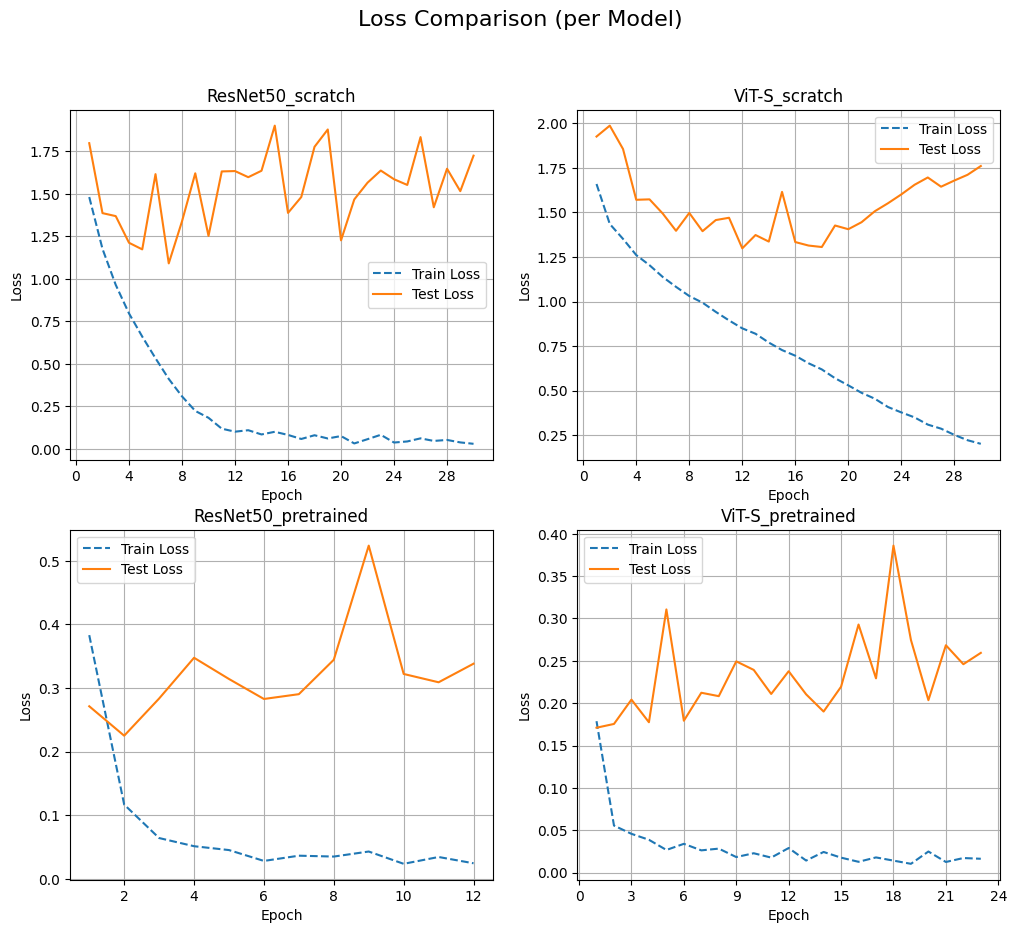

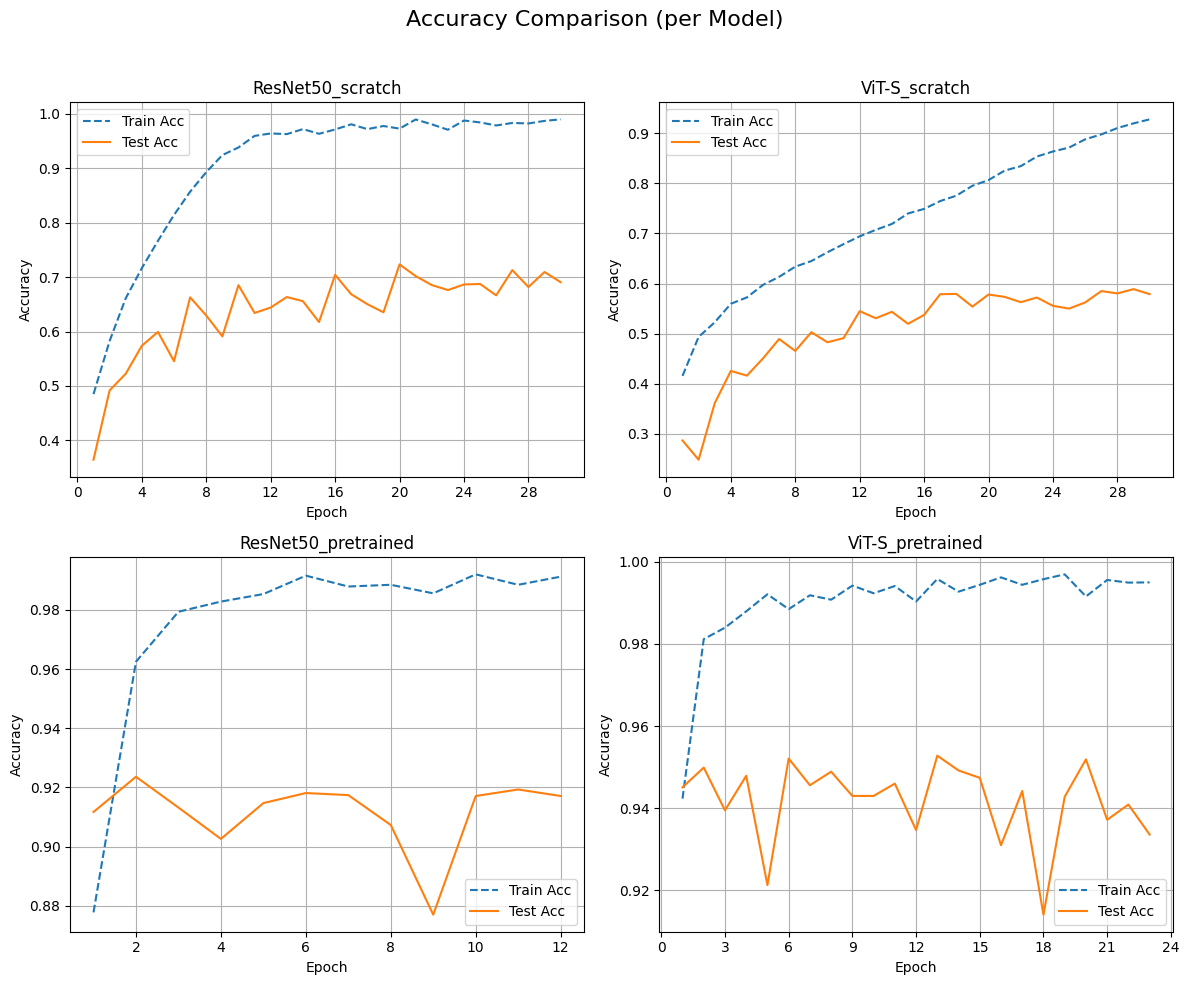

In [19]:
# CSV 파일 경로 로드 및 정렬
csv_files = sorted(glob.glob('./results/*.csv'))
csv_files = [f for f in csv_files if not os.path.basename(f).startswith("_")]
csv_files = sorted(csv_files,key=lambda f: experiment_order.index(os.path.basename(f).replace(".csv", "")))

# subplot
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(12, 10))
fig_acc, axes_acc = plt.subplots(2, 2, figsize=(12, 10))

axes_loss = axes_loss.flatten()
axes_acc = axes_acc.flatten()

for idx, file in enumerate(csv_files):
    df = pd.read_csv(file)
    exp_name = os.path.basename(file).replace(".csv", "")

    # Loss subplot
    axes_loss[idx].plot(df["epoch"], df["train_loss"], label="Train Loss", linestyle='--')
    axes_loss[idx].plot(df["epoch"], df["test_loss"], label="Test Loss", linestyle='-')
    axes_loss[idx].set_title(f"{exp_name}")
    axes_loss[idx].set_xlabel("Epoch")
    axes_loss[idx].set_ylabel("Loss")
    axes_loss[idx].grid(True)
    axes_loss[idx].legend()
    axes_loss[idx].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Accuracy subplot
    axes_acc[idx].plot(df["epoch"], df["train_acc"], label="Train Acc", linestyle='--')
    axes_acc[idx].plot(df["epoch"], df["test_acc"], label="Test Acc", linestyle='-')
    axes_acc[idx].set_title(f"{exp_name}")
    axes_acc[idx].set_xlabel("Epoch")
    axes_acc[idx].set_ylabel("Accuracy")
    axes_acc[idx].grid(True)
    axes_acc[idx].legend()
    axes_acc[idx].xaxis.set_major_locator(MaxNLocator(integer=True))

# 전체 타이틀과 저장
fig_loss.suptitle("Loss Comparison (per Model)", fontsize=16)
fig_acc.suptitle("Accuracy Comparison (per Model)", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig_loss.savefig("./results/loss_subplot.png")
fig_acc.savefig("./results/acc_subplot.png")

plt.show()

## (2) Metrics

,experiment,model,pretrained,Test Acc,precision,recall,f1_score
0,ResNet50_scratch,ResNet50,False,0.7234,0.738490,0.7234,0.725859
1,ViT-S_scratch,ViT-S,False,0.5889,0.623620,0.5889,0.584065
2,ResNet50_pretrained,ResNet50,True,0.9236,0.926152,0.9236,0.923810
3,ViT-S_pretrained,ViT-S,True,0.9528,0.954322,0.9528,0.952730


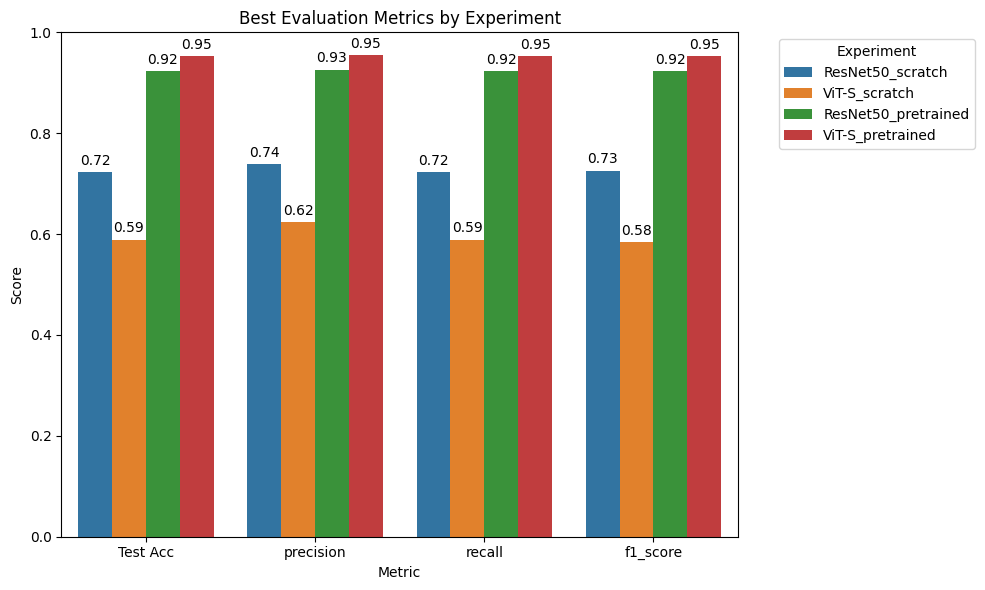

In [20]:
# 출력
display(summary_df)

# metric 정렬
metric_names = ["Test Acc", "precision", "recall", "f1_score"]
melted = summary_df.melt(
    id_vars="experiment",
    value_vars=metric_names,
    var_name="Metric",
    value_name="Score"
)

# barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="experiment")
plt.title("Best Evaluation Metrics by Experiment")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# 숫자 표시
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

# 저장 & 출력
plt.savefig("./results/metrics_summary_barplot.png")
plt.show()


## (3) GradCAM

In [21]:
def evaluate_with_samples(model, dataloader, device, max_per_class=3):
    model.eval()
    correct_samples = []
    wrong_samples = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for i in range(images.size(0)):
                image = images[i].detach().cpu()
                true = labels[i].item()
                pred = preds[i].item()

                sample = {
                    "image": image,
                    "true": true,
                    "pred": pred
                }

                if true == pred and len(correct_samples) < max_per_class:
                    correct_samples.append(sample)
                elif true != pred and len(wrong_samples) < max_per_class:
                    wrong_samples.append(sample)

                if len(correct_samples) >= max_per_class and len(wrong_samples) >= max_per_class:
                    return correct_samples, wrong_samples

    return correct_samples, wrong_samples


In [22]:
def get_gradcam_image(cam, sample, device):
    input_tensor = sample["image"].unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # [H, W]

    img_np = sample["image"].permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return img_np, cam_image

🔍 Evaluating ResNet50_pretrained


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


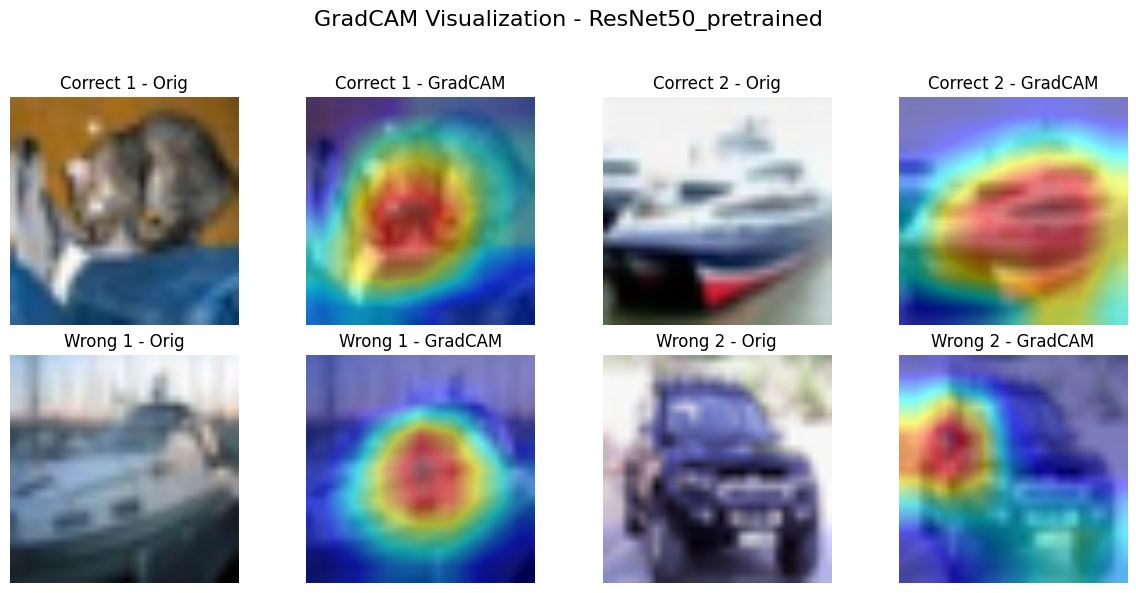

🔍 Evaluating ResNet50_scratch


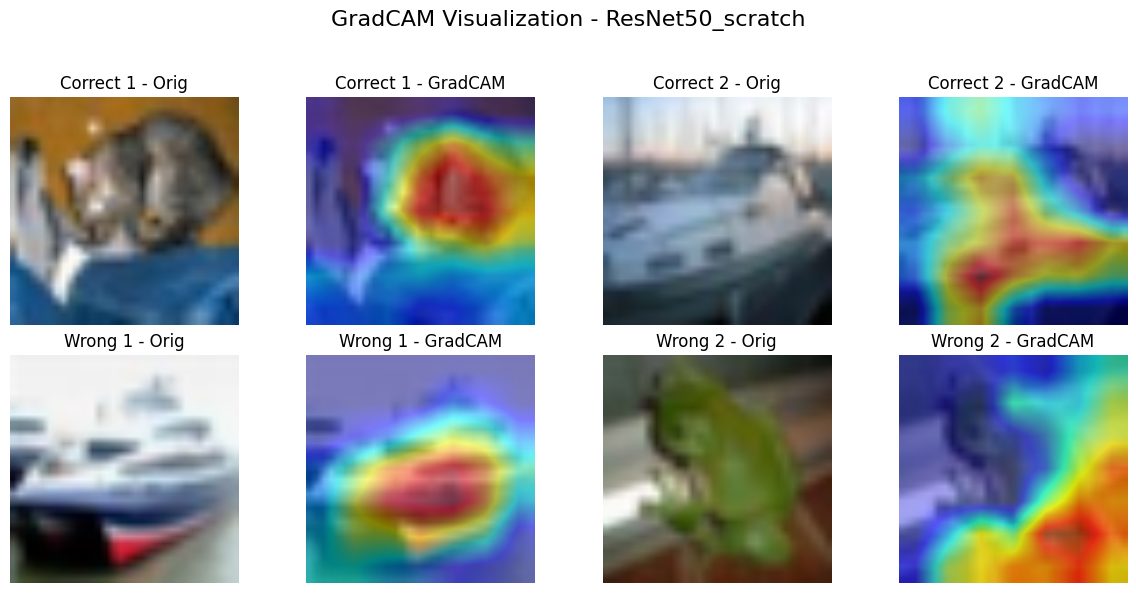

🔍 Evaluating ViT-S_pretrained


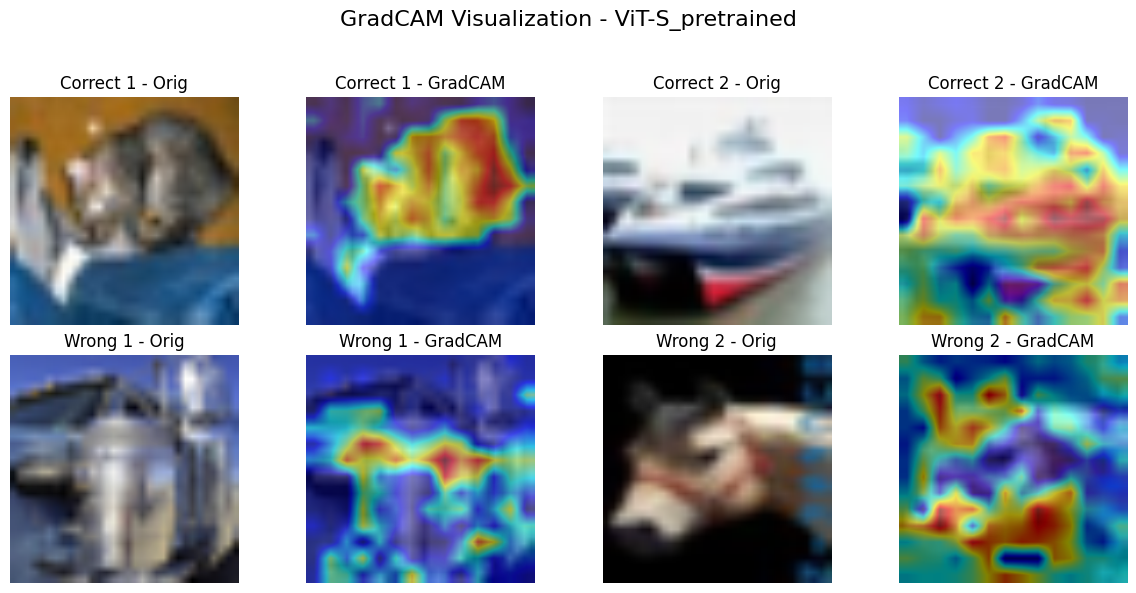

🔍 Evaluating ViT-S_scratch


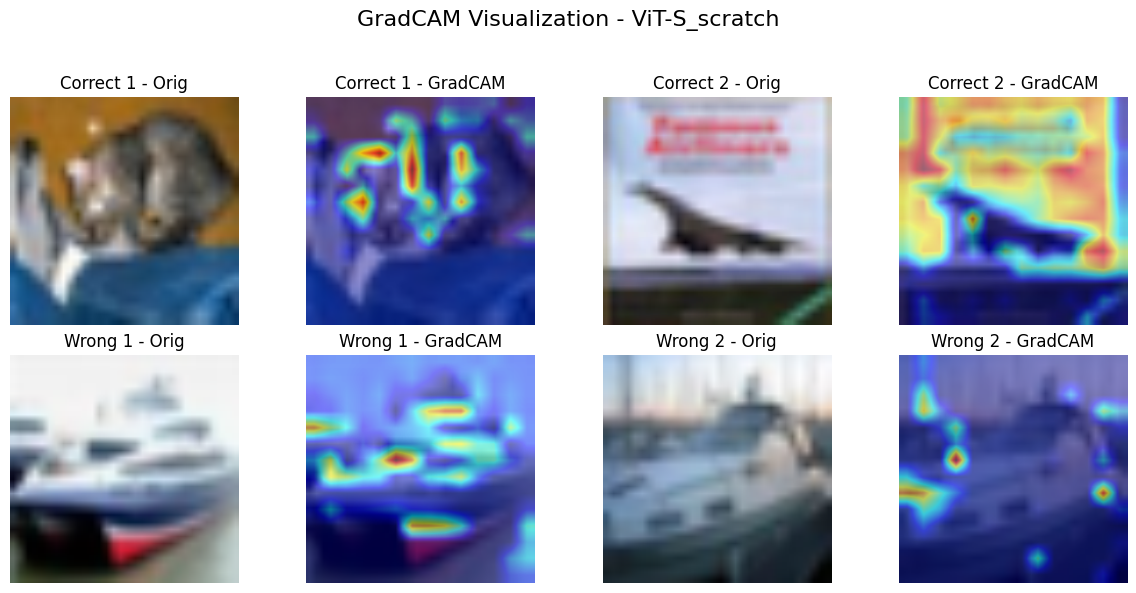

In [23]:
EXPERIMENTS = [
    "ResNet50_pretrained",
    "ResNet50_scratch",
    "ViT-S_pretrained",
    "ViT-S_scratch"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reshape_transform 함수 추가 (ViT용)
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

for exp in EXPERIMENTS:
    print(f"🔍 Evaluating {exp}")

    # 1) 모델 생성
    if "ResNet50" in exp:
        model = ResNet50(num_classes=10)
    elif "ViT" in exp:
        model = ViT_S(pretrained=False, num_classes=10)

    # 2) 모델 device 이동
    model.to(device)

    # 3) 가중치 로드
    ckpt_path = f"./checkpoints/best_{exp}.pth"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # 4) GradCAM 객체 생성 (ViT는 reshape_transform 포함)
    if "ResNet50" in exp:
        target_layer = model.layer4[-1]
        cam = GradCAM(model=model, target_layers=[target_layer])
    elif "ViT" in exp:
        target_layer = model.backbone.blocks[-1].norm1
        cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

    # 5) 샘플 평가
    correct_samples, wrong_samples = evaluate_with_samples(model, test_loader, device)

    save_dir = f"./gradcam"
    os.makedirs(save_dir, exist_ok=True)

    num_samples = 2

    correct_sample = correct_samples[:num_samples]
    wrong_sample = wrong_samples[:num_samples]

    fig, axes = plt.subplots(2, num_samples * 2, figsize=(3 * num_samples * 2, 6))

    for i in range(num_samples):
        # i번째 샘플에서 GradCAM
        orig_corr, cam_corr = get_gradcam_image(cam, correct_samples[i], device)
        orig_wrong, cam_wrong = get_gradcam_image(cam, wrong_samples[i], device)

        # 맞춘 원본
        axes[0, i * 2].imshow(orig_corr)
        axes[0, i * 2].set_title(f"Correct {i+1} - Orig")
        axes[0, i * 2].axis("off")

        # 맞춘 GradCAM
        axes[0, i * 2 + 1].imshow(cam_corr)
        axes[0, i * 2 + 1].set_title(f"Correct {i+1} - GradCAM")
        axes[0, i * 2 + 1].axis("off")

        # 틀린 원본
        axes[1, i * 2].imshow(orig_wrong)
        axes[1, i * 2].set_title(f"Wrong {i+1} - Orig")
        axes[1, i * 2].axis("off")

        # 틀린 GradCAM
        axes[1, i * 2 + 1].imshow(cam_wrong)
        axes[1, i * 2 + 1].set_title(f"Wrong {i+1} - GradCAM")
        axes[1, i * 2 + 1].axis("off")

    plt.suptitle(f"GradCAM Visualization - {exp}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    plt.savefig(os.path.join(save_dir, f"{exp}_gradcam_multi.png"))
    plt.show()
    plt.close()